# Star Pyramid Meshes

An example of an application of the `circle_bundles` pipeline to a dataset where the underlying model is a 3-manifold with non-trivial Euler class. Persistence diagrams in dimension higher than 2 are generally intractible (or at least very expensive) to compute, particularly when the ambient dimension of the dataset itself is large. A local-to-global analysis therefore is needed to capture the topology.

We generate a synthetic dataset by applying random $SO(3)$ rotations to the vertices of a triangle mesh and storing the results as vectors in $\mathbb{R}^{3n}$; one can show that the $SO(3)$-orbit of the original mesh vertices under this action is a 3-manifold homeomorphic to $SO(3)$ itself. We choose an $\mathbb{S}^{2}$-valued feature map for analysis and model the dataset as a discrete aproximate circle bundle. We then compute characteristic classes to confirm the global topology. 

Finally, we consider a subset of the data which projects to a neighborhood of the equator $z = 0$ in $\mathbb{S}^{2}$ and compute a toroidal coordinate system for this part of the data. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ripser import ripser
from persim import plot_diagrams

import circle_bundles as cb

First, generate a dataset of triangle meshes, stored as vectors of length $3\times 6 = 18$:

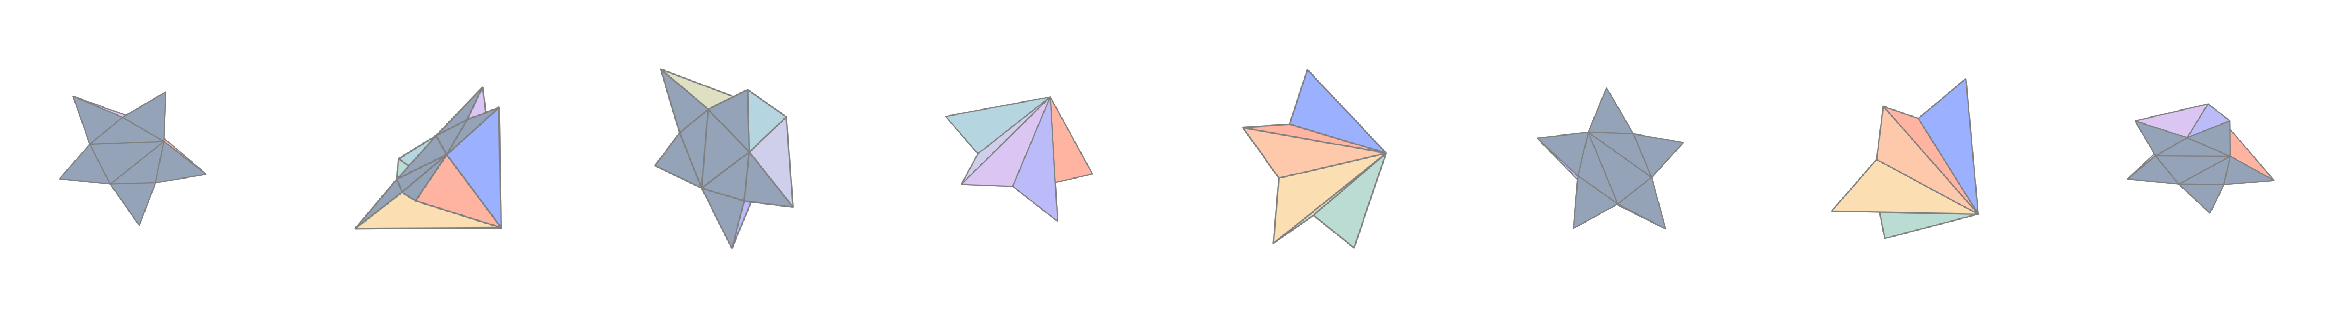

In [2]:
#Create the template triangle mesh
mesh = cb.make_star_pyramid(n_points = 5, height = 1)

#Create a visualization function
vis_func = cb.make_star_pyramid_visualizer(mesh)

n_samples = 5000
rng = np.random.default_rng(0)
so3_data = cb.sample_so3(n_samples, rng=rng)[0]

data = cb.get_mesh_sample(mesh, so3_data)

#View a small sample of the dataset:
fig = cb.show_data_vis(
    data, 
    vis_func, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first", 
    pad_frac=0.3)
plt.show()


Show a PCA visualization of the dataset:

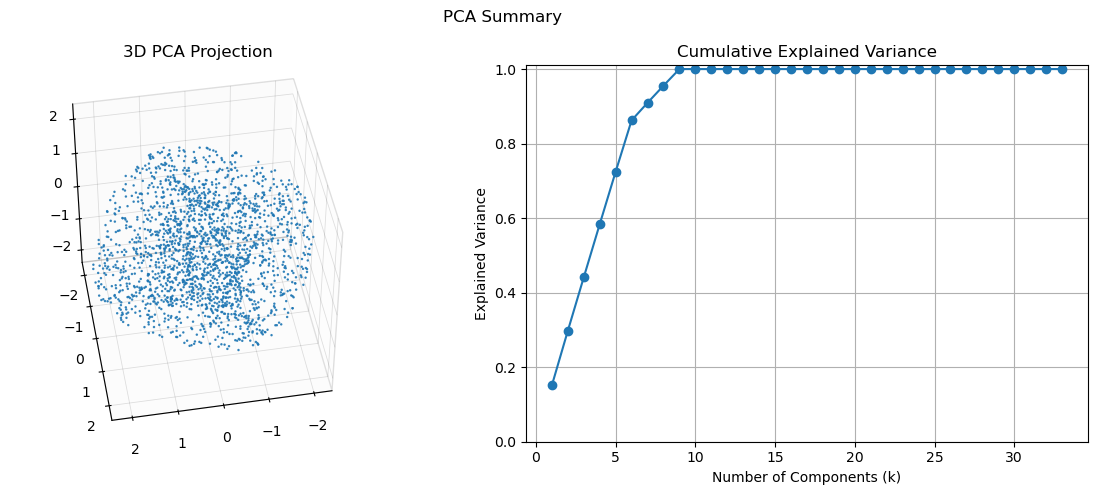

In [3]:
cb.show_pca(data, size = 0.1, elev = 45, azim = 80)

Recall that for $SO(3)\cong\mathbb{RP}^{3}$, one has

$
\hspace{2cm}H_k(\mathrm{SO}(3);\mathbb{Z})
\cong
\begin{cases}
\mathbb{Z} & k=0,3,\\
\mathbb{Z}_2 & k=1,\\
0 & \text{otherwise.}
\end{cases}
$

A persistence computation in dimension 3 is intractible here, but compute persistence diagrams in dimensions $\leq 2$ on subsamples of the dataset:

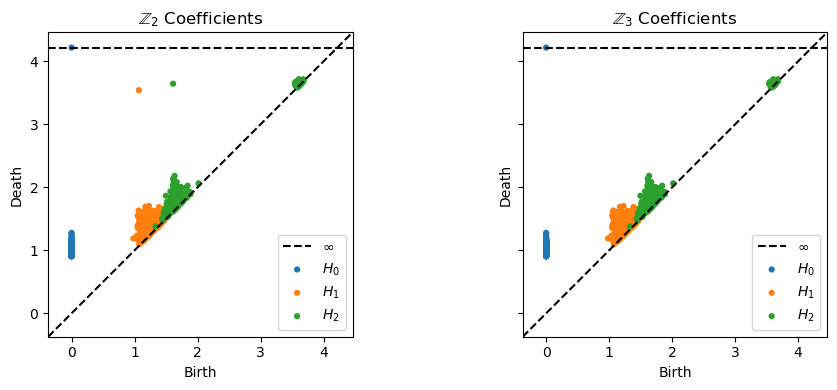

In [4]:
dgms_2 = ripser(data, coeff=2, maxdim=2, n_perm=500)["dgms"]
dgms_3 = ripser(data, coeff=3, maxdim=2, n_perm=500)["dgms"]

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)

plot_diagrams(dgms_2, ax=axes[0], title=r"$\mathbb{Z}_{2}$ Coefficients")
plot_diagrams(dgms_3, ax=axes[1], title=r"$\mathbb{Z}_{3}$ Coefficients")

plt.tight_layout()
plt.show()

As expected, the persistence diagrams are consistent with the homology of $\mathbb{RP}^{2}$, the 2-skeleton of $SO(3)$.

To capture the full topology, define a feature map as follows: given a mesh whose first three vertices are $v_{1},v_{2},v_{3}\in \mathbb{R}^{3}$, compute the oriented unit normal defined by 

$$\frac{(v_{2}-v_{1})\times (v_{3} - v_{1})}{|(v_{2} - v_{1})\times (v_{3} - v_{1})|}$$

Note that for meshes in the dataset, the first three vertices are never colinear, so this map is well-defined. Moreover, it happens to be the case that the oriented unit normal vector coincides with the axis of rotational symmetry.  While this is not strictly needed (and does not affect the isomorphism type of the underlying bundle structure), it is convenient for visualization and interpretation. 

Compute the base projections to $\mathbb{S}^{2}$, represented as vectors in $\mathbb{R}^{3}$:

In [3]:
base_points = cb.mesh_vertex_normals(data)

Construct a (good) open cover $\mathcal{U} = \{U_{j}\}_{j=1}^{60}$ of $\mathbb{S}^{2}$ using a collection of nearly equidistant landmark points (see API reference section):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 174$
- $\#(\text{2-simplices}) = 116$
- *No recorded simplices in dimensions* $\ge 3$

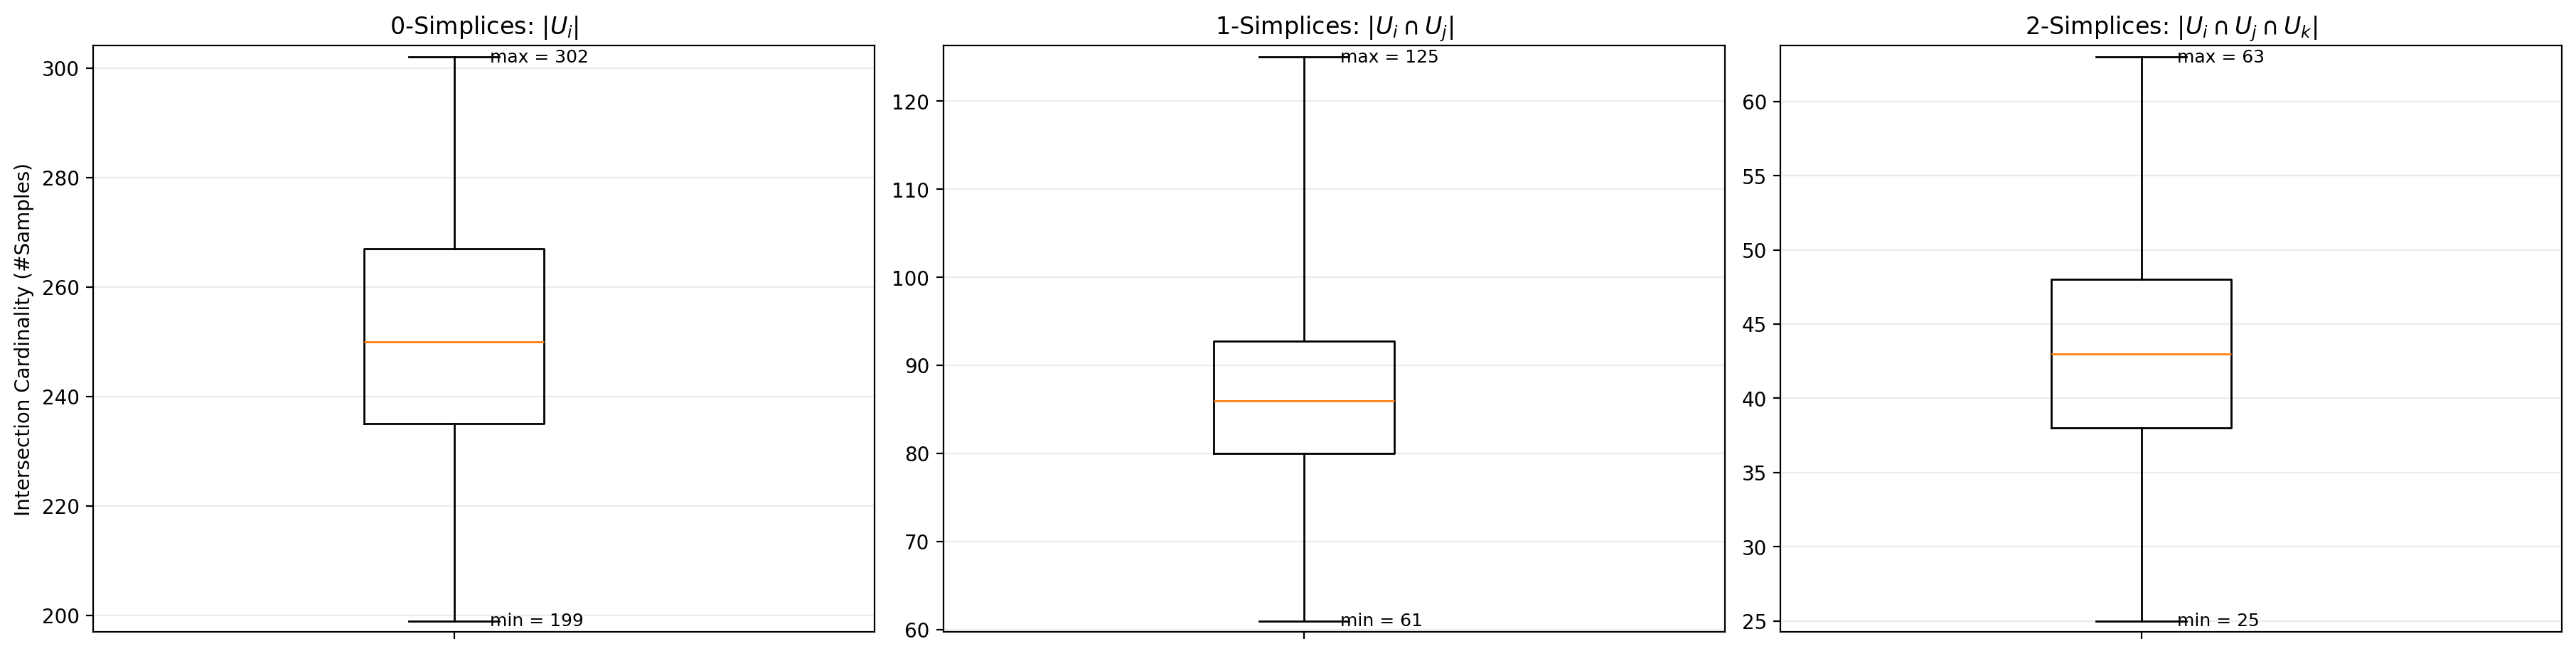

In [4]:
n_landmarks = 60
cover = cb.get_s2_fibonacci_cover(base_points, n_vertices = n_landmarks)
bundle = cb.Bundle(X = data, cover = cover, show_summary = True)

Observe that the nerve of $\mathcal{U}$ has Euler characteristic $\chi = 60 - 174 + 116 = 2$, as expected for $\mathbb{S}^{2}$.

Compute a PCA projection for the data in each set $\pi^{-1}(U_{j})$:

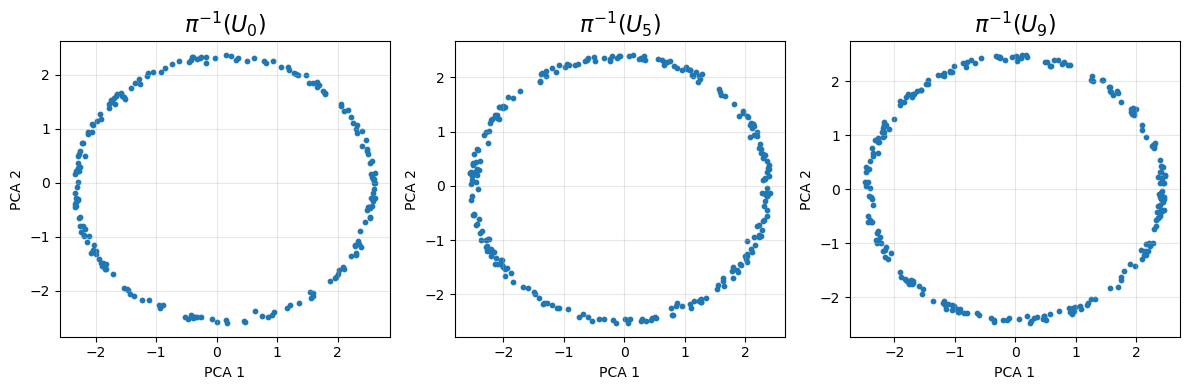

In [7]:
fig, axes = cb.get_local_pca(data, 
                      cover.U,
                      to_view = [0,5,9],
                     )
plt.show()

The diagrams suggest that the data in each $\pi^{-1}(U_{j})$ is concentrated around a geometric circle, supporting the hypothesis that the dataset has the structure of a discrete approximate circle bundle. 

Compute local circular coordinates with $\text{PCA}_{2}$, approximate transition matrices and characteristic clases:

In [5]:
triv_result = bundle.get_local_trivs()
class_result = bundle.get_classes(show_classes = True)

<IPython.core.display.Math object>

From this computation, we can infer that the data is concentrated around a 3-manifold with the topology of $SO(3)$. 

Now, restrict the bundle to the equator $\mathbb{S}^{1}\subset \mathbb{S}^{2}$:

In [6]:
eps = 0.15  # thickness of equatorial band (in the chosen S^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps

eq_data = bundle.X[eq_mask]

# Parametrize the equator by an angle in S^1 
eq_base_angles = np.arctan2(base_points[eq_mask, 1], base_points[eq_mask, 0]) % (2*np.pi)

print(f"Equator band: {eq_data.shape[0]} / {bundle.X.shape[0]} samples (eps={eps}).")


Equator band: 698 / 5000 samples (eps=0.15).


Constuct an open cover of $\mathbb{S}^{1}$ by metric balls around equally-spaced landmark points, then construct the restricted bundle object:

In [7]:
n_eq_landmarks = 12
eq_landmarks = np.linspace(0, 2*np.pi, n_eq_landmarks, endpoint=False)

overlap = 1.6
radius = overlap * np.pi / n_eq_landmarks

eq_cover = cb.get_metric_ball_cover(
    eq_base_angles.reshape(-1,1), 
    eq_landmarks.reshape(-1,1), 
    radius = radius, 
    metric = cb.S1AngleMetric()
)

eq_bundle = cb.Bundle(X = eq_data, cover = eq_cover)
eq_triv_result = eq_bundle.get_local_trivs()
eq_class_result = eq_bundle.get_classes(show_classes = True)


<IPython.core.display.Math object>

Observe that the restricted bundle is orientable, hence trivial, as expected. Construct a global toroidal coordinate system by synchronizing local circular coordinates:

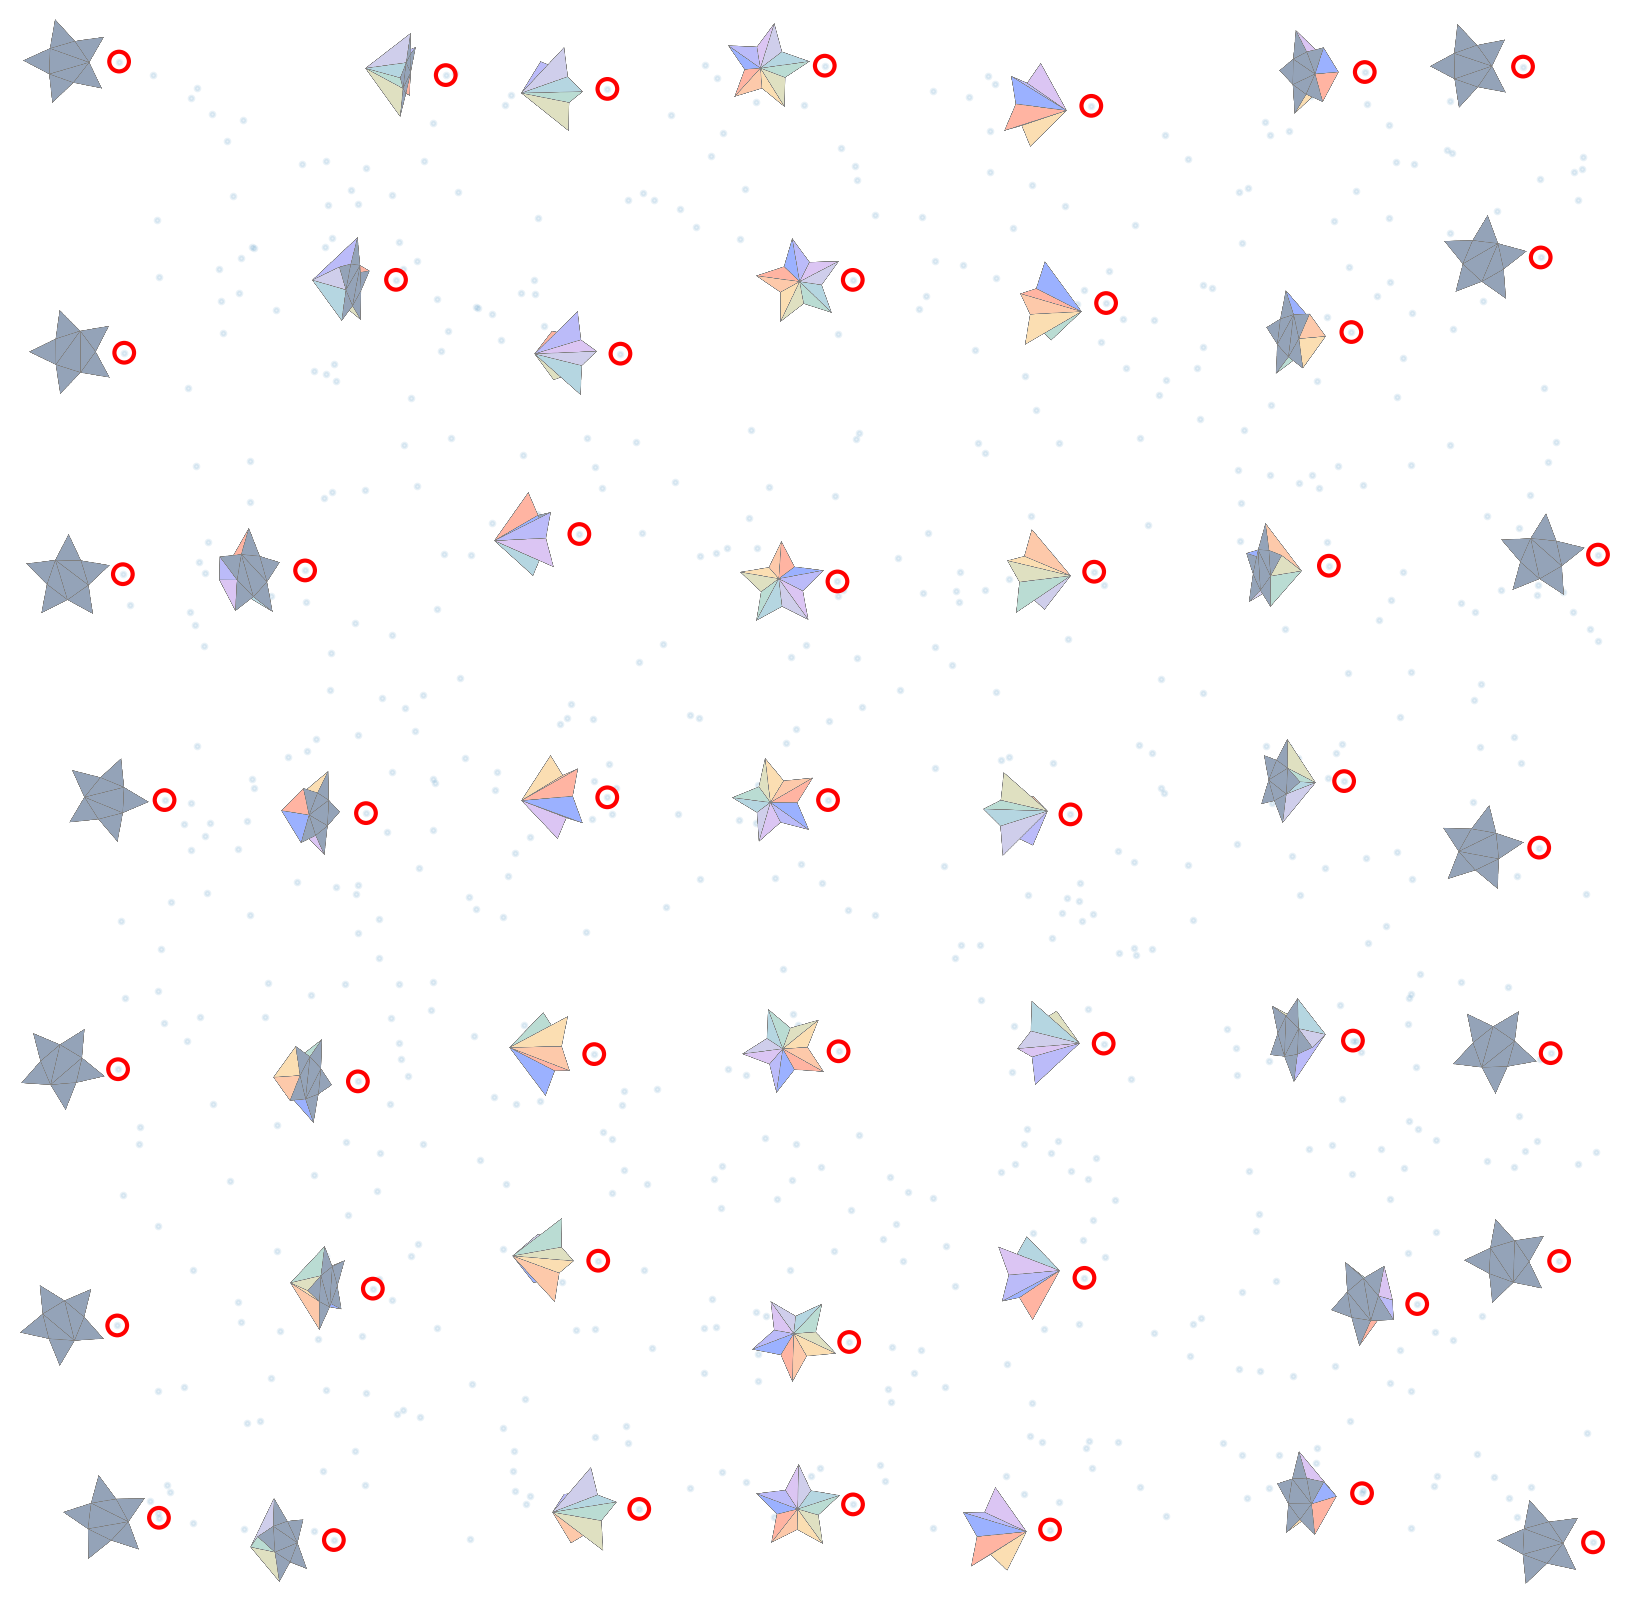

In [8]:
F = eq_bundle.get_global_trivialization()

#show a visualization of the coordinatized meshes:

coords = np.column_stack([eq_base_angles, F])

fig = cb.scatter_lattice_vis(
    eq_data, 
    coords, 
    vis_func, 
    per_row = 7, 
    per_col = 7,
    padding = 0,
    )
plt.show()


Base projection angle varies from $0$ to $2\pi$ along the $x$-direction and fiber angle varies from $0$ to $2\pi$ along the $y$-direction.  Notice that base projection roughly corresponds to axis of symmetry, as expected.  The coordinatized meshes in each column approximately traverse a full rotation about the axis of symmetry. Meshes on opposite edges of the diagram roughly correspond, reflecting the toroidal topology of the restricted dataset. 